# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Original Dataset : https://data.mendeley.com/datasets/tywbtsjrjv/1

Plant_leaf_diseases_dataset_without_augmentation.zip

# **Import Libraries and Set Up Paths**

In [ ]:

import warnings
warnings.filterwarnings("ignore")
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import shutil


base_dir = 'PlantLeafDiseasesDataset'
zip_file_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation.zip'
data_dir = os.path.join(base_dir, 'Plant_leave_diseases_dataset_without_augmentation')

os.makedirs(base_dir, exist_ok=True)


if os.path.exists(zip_file_path):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(base_dir)


# **Split Data into Train, Validation, and Test Sets**

In [ ]:

def split_data(data_dir, output_dir, test_size=0.2, val_size=0.2):
    class_dirs = glob.glob(os.path.join(data_dir, "*"))
    os.makedirs(output_dir, exist_ok=True)

    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        images = glob.glob(os.path.join(class_dir, "*"))


        train_val_images, test_images = train_test_split(images, test_size=test_size)


        train_images, val_images = train_test_split(train_val_images, test_size=val_size / (1 - test_size))

        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img_path in split_images:
                shutil.copy(img_path, os.path.join(split_dir, os.path.basename(img_path)))


split_data(data_dir, base_dir)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


# **Data Preprocessing and Augmentation**

In [ ]:
img_width, img_height = 256, 256
batch_size = 32
input_shape = (img_width, img_height, 3)


train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False
)


Found 33245 images belonging to 39 classes.
Found 11098 images belonging to 39 classes.
Found 11105 images belonging to 39 classes.


# **Build and Compile CNN Model**

In [ ]:

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 252, 252, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 82, 82, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 41, 41, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 39, 39, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 23104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      11,829,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 39)                  │           5,031 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,930,631 (45.51 MB)

 Trainable params: 11,930,631 (45.51 MB)

 Non-trainable params: 0 (0.00 B)

# **Train the Model**

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)


Epoch 1/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 520s 490ms/step - accuracy: 0.4026 - loss: 2.2276 - val_accuracy: 0.7711 - val_loss: 0.7394
Epoch 2/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 547s 481ms/step - accuracy: 0.7543 - loss: 0.7833 - val_accuracy: 0.8288 - val_loss: 0.5411
Epoch 3/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 558s 477ms/step - accuracy: 0.8246 - loss: 0.5460 - val_accuracy: 0.8388 - val_loss: 0.5122
Epoch 4/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 502s 477ms/step - accuracy: 0.8529 - loss: 0.4503 - val_accuracy: 0.8793 - val_loss: 0.3753
Epoch 5/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 507s 482ms/step - accuracy: 0.8808 - loss: 0.3626 - val_accuracy: 0.8980 - val_loss: 0.3134
Epoch 6/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 518s 496ms/step - accuracy: 0.8915 - loss: 0.3311 - val_accuracy: 0.9184 - val_loss: 0.2544
Epoch 7/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 499s 478ms/step - accuracy: 0.9103 - loss: 0.2804 - val_accuracy: 0.9300 - val_loss: 0.2190
Epoch 8/10
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 508s 487ms/step - ac

# **Evaluate and Analyze the Model**

In [ ]:

test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


y_test = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


348/348 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9106 - loss: 0.2885
Test Loss: 0.25356781482696533
Test Accuracy: 0.9208464622497559
348/348 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step
Precision: 0.93
Recall: 0.92
F1 Score: 0.92


# **Plot Training History**

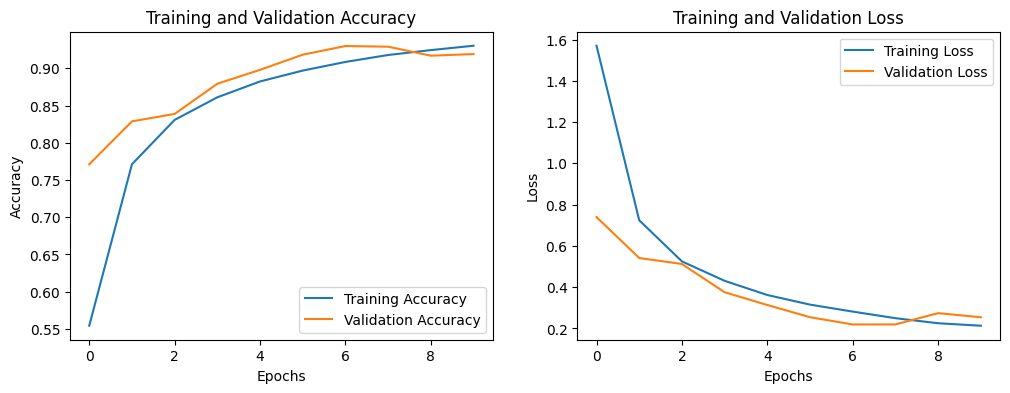

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Plot confusion matrix**

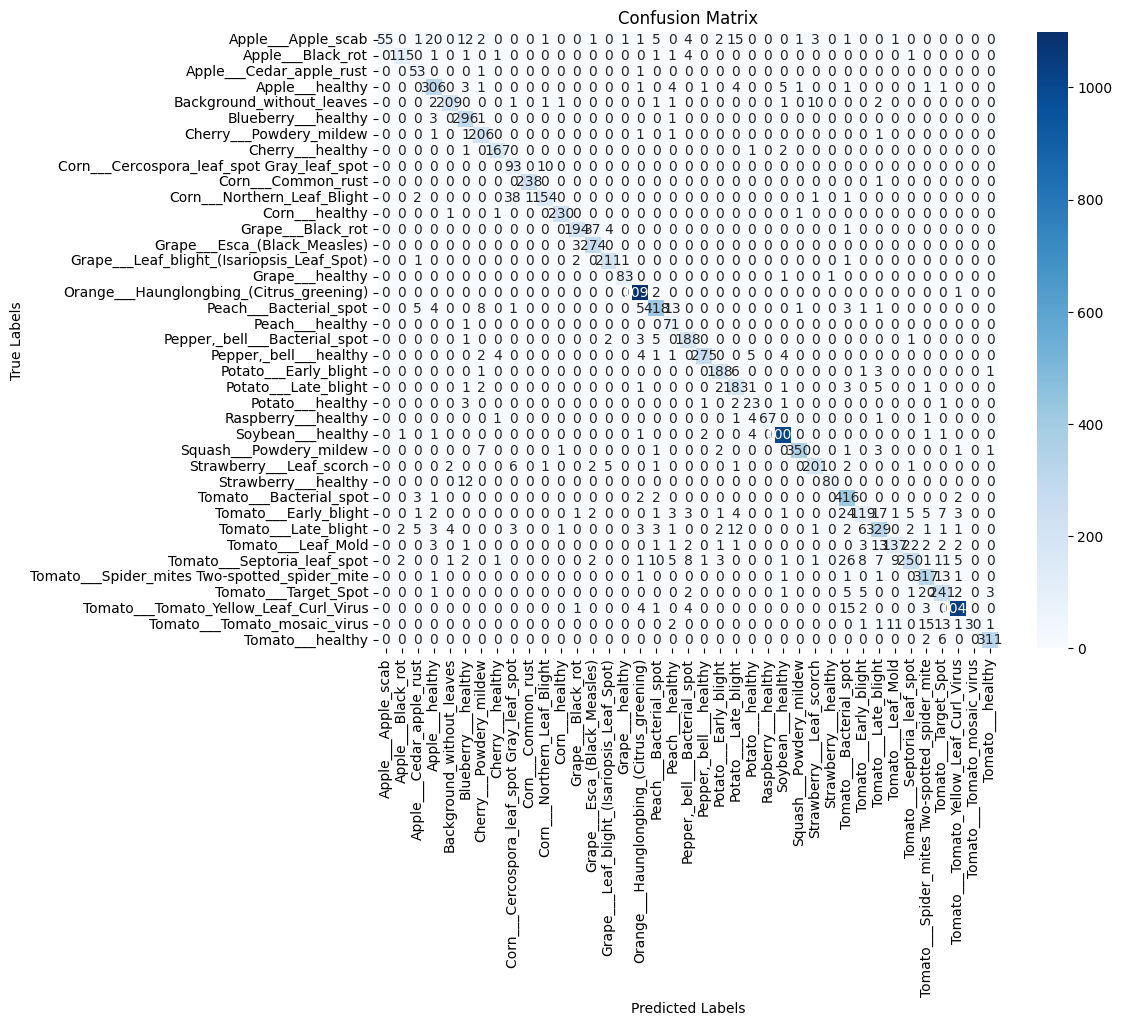

In [ ]:
class_labels = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Save Model**

In [ ]:

model.save('crop_model.keras')
print("Model saved as 'crop_model.keras'.")


model.save_weights('crop_model.weights.h5')
print("Model weights saved as 'crop_model.weights.h5'.")

class_indices = train_generator.class_indices
print("Class indices used during training:")
print(class_indices)

classes = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]
print("Classes:", classes)


Model saved as 'crop_model.keras'.
Model weights saved as 'crop_model.weights.h5'.
Class indices used during training:
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___

# **Load Model**

In [ ]:
from keras.models import load_model


model = load_model('crop_model.keras')


Classes = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy',
    'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight',
    'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
    'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]


print("Classes loaded for predictions:")
print(Classes)


Classes loaded for predictions:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', '

# **Prediction Function**

In [ ]:
def predict_disease(img_path, model, class_labels):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

# **Check For Images**

In [ ]:
import os


directory_to_check = '/content/PlantLeafDiseasesDataset/test/Tomato___Bacterial_spot'

image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')


def list_images_in_directory(directory, extensions):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extensions):
                print(os.path.join(root, file))

list_images_in_directory(directory_to_check, image_extensions)


In [ ]:
import os


directory_to_check = '/content/PlantLeafDiseasesDataset/test/Tomato___healthy'

image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')

def list_images_in_directory(directory, extensions):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extensions):
                print(os.path.join(root, file))

list_images_in_directory(directory_to_check, image_extensions)


# **Predicting**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


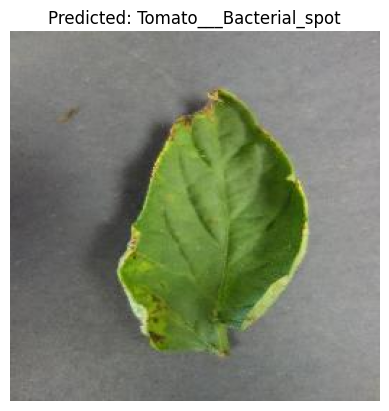

Predicted Disease: Tomato___Bacterial_spot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def prepare(img_path, img_width, img_height):
    try:
        img = image.load_img(img_path, target_size=(img_width, img_height))
        x = image.img_to_array(img) / 255.0
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error in preparing the image: {e}")
        return None

test_image_path = '/content/PlantLeafDiseasesDataset/test/Tomato___Bacterial_spot/image (1007).JPG'

if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"Test image not found at {test_image_path}")

input_image = prepare(test_image_path, img_width, img_height)

if input_image is not None:

    result = model.predict(input_image)
    predicted_class = class_labels[np.argmax(result)]

    plt.imshow(image.load_img(test_image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Predicted Disease: {predicted_class}")
else:
    print("Failed to prepare the image for prediction.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


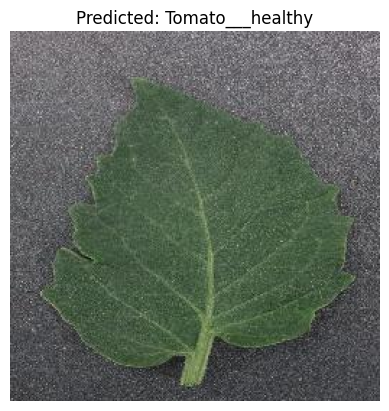

Predicted Disease: Tomato___healthy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os


def prepare(img_path, img_width, img_height):
    try:
        img = image.load_img(img_path, target_size=(img_width, img_height))
        x = image.img_to_array(img) / 255.0
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error in preparing the image: {e}")
        return None

test_image_path = '/content/PlantLeafDiseasesDataset/test/Tomato___healthy/image (1311).JPG'


if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"Test image not found at {test_image_path}")

input_image = prepare(test_image_path, img_width, img_height)

if input_image is not None:

    result = model.predict(input_image)
    predicted_class = class_labels[np.argmax(result)]


    plt.imshow(image.load_img(test_image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Predicted Disease: {predicted_class}")
else:
    print("Failed to prepare the image for prediction.")
